---

_You are currently looking at **version 1.1** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-machine-learning/resources/bANLa) course resource._

---

## Assignment 4 - Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    train.csv - the training set (all tickets issued 2004-2011)
    test.csv - the test set (all tickets issued 2012-2016)
    addresses.csv & latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32
       
### Hints

* Make sure your code is working before submitting it to the autograder.

* Print out your result to see whether there is anything weird (e.g., all probabilities are the same).

* Generally the total runtime should be less than 10 mins. You should NOT use Neural Network related classifiers (e.g., MLPClassifier) in this question. 

* Try to avoid global variables. If you have other functions besides blight_model, you should move those functions inside the scope of blight_model.

* Refer to the pinned threads in Week 4's discussion forum when there is something you could not figure it out.

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import Imputer,\
                                  LabelEncoder,\
                                  MinMaxScaler,\
                                  OneHotEncoder,\
                                  StandardScaler
                
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import auc, roc_auc_score, accuracy_score, classification_report
from sklearn.preprocessing import Imputer

def blight_model():
    

    addresses = pd.read_csv('addresses.csv')
    latlons = pd.read_csv('latlons.csv')

    train_data = pd.read_csv('train.csv', encoding = "ISO-8859-1")
    test_data = pd.read_csv('test.csv')
    
    merged_address = pd.merge(addresses, latlons, on='address', how='left')
    
    train_data_merged = pd.merge(train_data, merged_address, on='ticket_id', how='left')
    test_data_merged = pd.merge(test_data, merged_address, on='ticket_id', how='left')
    
    num_cols = ['fine_amount', 
    #           'admin_fee',
    #           'state_fee', # perfectly correlated with admin_fee
                'late_fee',
            'discount_amount',
    #           'clean_up_cost', # all zeros
                'judgment_amount',
                'lat',
                'lon']

    cat_cols = ['agency_name',
                'inspector_name',
                #'zip_code',
                #'violation_street_name',
                'violation_code']

    train_data_merged = train_data_merged[num_cols+cat_cols+['compliance']].dropna()
    test_data_merged =  test_data_merged[num_cols+cat_cols]
    
    
    imp = Imputer(missing_values=np.nan, strategy='mean')
    imp.fit(test_data_merged[num_cols])
    test_data_num = imp.transform(test_data_merged[num_cols])
    test_data_num = pd.DataFrame(test_data_num, columns=num_cols)

    test_data_merged = pd.concat([test_data_num, 
                                  test_data_merged[cat_cols]],
                                  axis=1)
    
    all_data_merged = train_data_merged.append(test_data_merged)
    #all_data_merged.size #2208740
    scaler = MinMaxScaler()
    
    all_num = pd.DataFrame(scaler.fit_transform(all_data_merged[num_cols]), columns=num_cols)
    all_cat = pd.get_dummies(all_data_merged[cat_cols]).reset_index().drop('index', axis=1)
    all_data_final = pd.concat([all_num, 
                                all_cat,
                                all_data_merged['compliance'].reset_index().drop('index', axis=1)],
                                axis=1)
    train_data = all_data_final[~all_data_final['compliance'].isnull()]
    X_test = all_data_final[all_data_final['compliance'].isnull()]
    X_test.drop('compliance', axis=1, inplace=True)
    split = StratifiedShuffleSplit(n_splits=1, test_size = 0.2, random_state = 42)
    for train_index, val_index in split.split(train_data, train_data['compliance']):
        X_train = train_data.loc[train_index]
        X_val = train_data.loc[val_index]
    
        y_train = X_train['compliance']
        y_val = X_val['compliance']
    
        X_train.drop('compliance', inplace=True, axis=1)
        X_val.drop('compliance', inplace=True, axis=1)
        #clf = AdaBoostClassifier() 
        clf = GradientBoostingClassifier()
        #clf = RandomForestClassifier()
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_val)
        print(y_pred)
        #y_pred_dummy = pd.Series(np.zeros(y_val.size), index=y_val.index)
        print(classification_report(y_val, clf.predict(X_val)))

    y_test = clf.predict_proba(X_test)

    return y_test[:,1]

result = blight_model()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[[ 0.96402871  0.03597129]
 [ 0.98042424  0.01957576]
 [ 0.97863389  0.02136611]
 ..., 
 [ 0.96331163  0.03668837]
 [ 0.98083377  0.01916623]
 [ 0.9536087   0.0463913 ]]
             precision    recall  f1-score   support

        0.0       0.94      1.00      0.97     29657
        1.0       0.94      0.12      0.21      2319

avg / total       0.94      0.94      0.91     31976



In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import Imputer,\
                                  LabelEncoder,\
                                  MinMaxScaler,\
                                  OneHotEncoder,\
                                  StandardScaler
                
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, roc_auc_score

In [2]:
addresses = pd.read_csv('addresses.csv')
latlons = pd.read_csv('latlons.csv')
print(addresses.shape)
#print(addresses)
print(latlons.shape)
train_data = pd.read_csv('train.csv', encoding = "ISO-8859-1")
test_data = pd.read_csv('test.csv')
#print(train_data.head())
#print(test_data.head())
print(train_data.shape)
print(test_data.shape)
#print(train_data.dropna())

(311307, 2)
(121769, 3)


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(250306, 34)
(61001, 27)


In [8]:
display(addresses[:5])

,ticket_id,address
0,22056,"2900 tyler, Detroit MI"
1,27586,"4311 central, Detroit MI"
2,22062,"1449 longfellow, Detroit MI"
3,22084,"1441 longfellow, Detroit MI"
4,22093,"2449 churchill, Detroit MI"


In [9]:
display(latlons[:5])

,address,lat,lon
0,"4300 rosa parks blvd, Detroit MI 48208",42.346169,-83.079962
1,"14512 sussex, Detroit MI",42.394657,-83.194265
2,"3456 garland, Detroit MI",42.373779,-82.986228
3,"5787 wayburn, Detroit MI",42.403342,-82.957805
4,"5766 haverhill, Detroit MI",42.407255,-82.946295


In [3]:
merged_address = pd.merge(addresses, latlons, on='address', how='left')

In [10]:
merged_address[merged_address['lat'].isnull()]

,ticket_id,address,lat,lon
65578,89535,"20424 bramford, Detroit MI",NaN,NaN
191722,223598,"445 fordyce, Detroit MI",NaN,NaN
245981,280256,"8300 fordyce, Detroit MI",NaN,NaN
270765,317124,"20424 bramford, Detroit MI",NaN,NaN
278656,329689,"8325 joy rd, Detroit MI 482O4",NaN,NaN
278722,329393,"1201 elijah mccoy dr, Detroit MI 48208",NaN,NaN
282231,333990,"12038 prairie, Detroit MI 482O4",NaN,NaN
305706,367165,"6200 16th st, Detroit MI 482O8",NaN,NaN


In [13]:
latlons[latlons['address']=='6200 16th st, Detroit MI 482O8']

,address,lat,lon
17293,"6200 16th st, Detroit MI 482O8",NaN,NaN


In [4]:
train_data_merged = pd.merge(train_data, merged_address, on='ticket_id', how='left')
test_data_merged = pd.merge(test_data, merged_address, on='ticket_id', how='left')

In [5]:
display(train_data_merged[:5])


,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance,address,lat,lon
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"2900 tyler, Detroit MI",42.390729,-83.124268
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0,"4311 central, Detroit MI",42.326937,-83.135118
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,...,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN,"1449 longfellow, Detroit MI",42.380516,-83.096069
3,22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441.0,LONGFELLOW,NaN,5.0,ST. CLAIR,DETROIT,...,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN,"1441 longfellow, Detroit MI",42.380570,-83.095919
4,22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","NATHANIEL, NEAL",2449.0,CHURCHILL,NaN,7449.0,CHURCHILL,DETROIT,...,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN,"2449 churchill, Detroit MI",42.145257,-83.208233


In [18]:
display(test_data_merged[:5])

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,grafitti_status,address,lat,lon
0,284932,Department of Public Works,"Granberry, Aisha B","FLUELLEN, JOHN A",10041.0,ROSEBERRY,NaN,141,ROSEBERRY,DETROIT,...,20.0,10.0,20.0,0.0,0.0,250.0,NaN,"10041 roseberry, Detroit MI",42.407581,-82.986642
1,285362,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,...,20.0,10.0,100.0,0.0,0.0,1130.0,NaN,"18520 evergreen, Detroit MI",42.426239,-83.238259
2,285361,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,...,20.0,10.0,10.0,0.0,0.0,140.0,NaN,"18520 evergreen, Detroit MI",42.426239,-83.238259
3,285338,Department of Public Works,"Talbert, Reginald","HARABEDIEN, POPKIN",1835.0,CENTRAL,NaN,2246,NELSON,WOODHAVEN,...,20.0,10.0,20.0,0.0,0.0,250.0,NaN,"1835 central, Detroit MI",42.309661,-83.122426
4,285346,Department of Public Works,"Talbert, Reginald","CORBELL, STANLEY",1700.0,CENTRAL,NaN,3435,MUNGER,LIVONIA,...,20.0,10.0,10.0,0.0,0.0,140.0,NaN,"1700 central, Detroit MI",42.308830,-83.121116


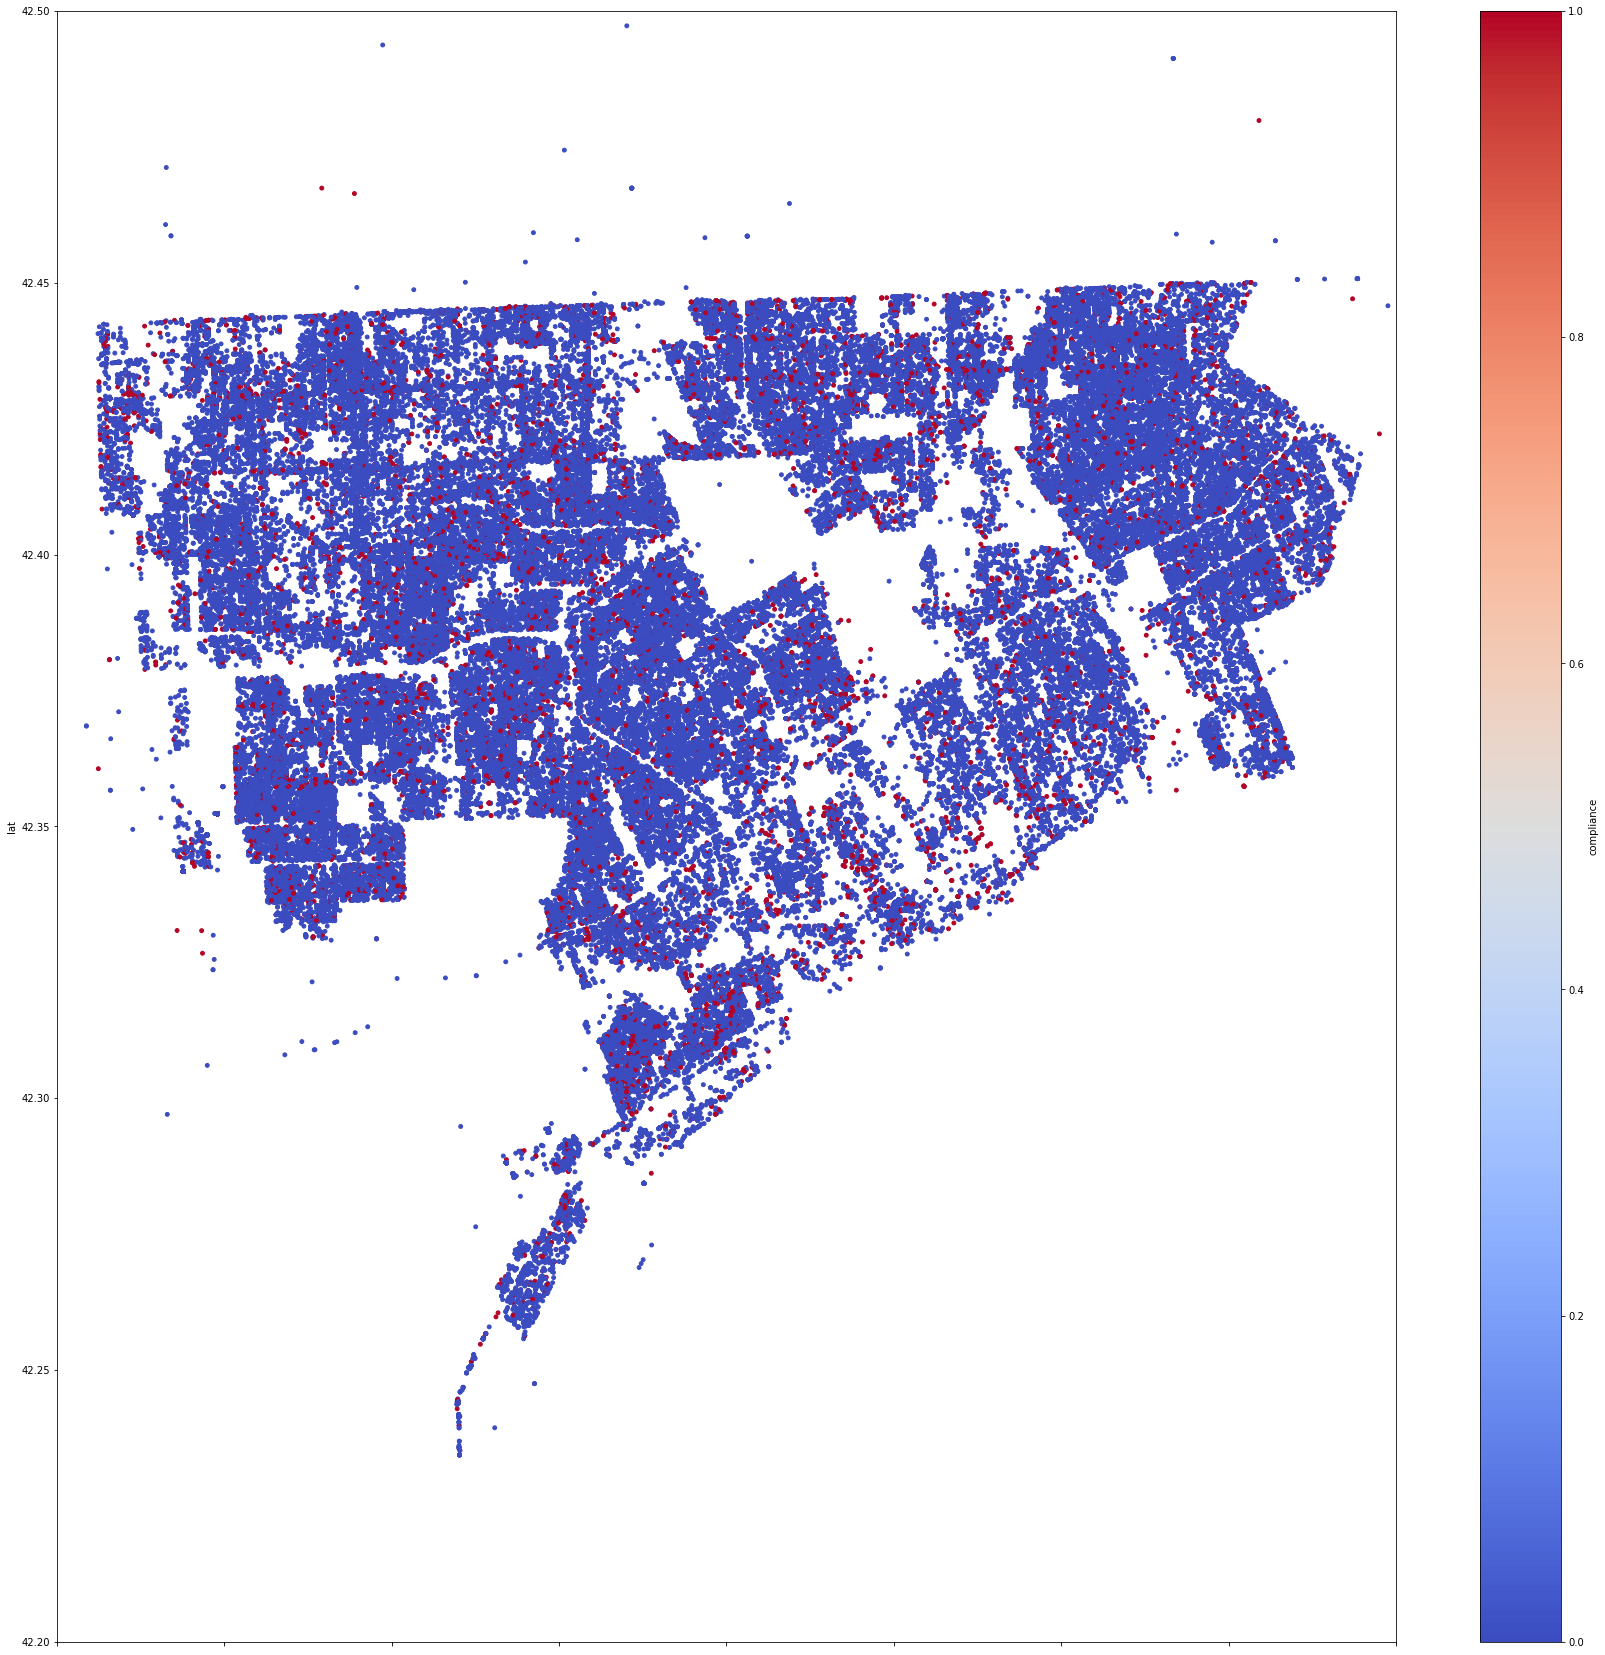

In [4]:

plt.figure()
train_data_merged.plot.scatter('lon', 
                               'lat', 
                               c='compliance', 
                               cmap='coolwarm', 
                               s=15,
                               ylim=(42.2,42.5),
                               xlim=(-83.3,-82.9),
                               figsize=(30,30));
#
plt.show()


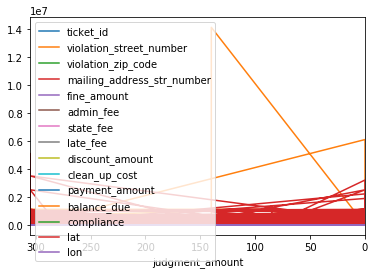

In [12]:
plt.figure()
train_data_merged.plot('judgment_amount');
plt.show()

In [5]:
num_cols = ['fine_amount', 
#            'admin_fee',
#            'state_fee', # perfectly correlated with admin_fee
            'late_fee',
            'discount_amount',
#            'clean_up_cost', # all zeros
            'judgment_amount',
            'lat',
            'lon']

cat_cols = ['agency_name',
            'inspector_name',
            #'zip_code',
            #'violation_street_name',
            'violation_code']

train_data_merged= train_data_merged[num_cols+cat_cols+['compliance']].dropna()


In [16]:
train_data_merged

,fine_amount,late_fee,discount_amount,judgment_amount,lat,lon,agency_name,inspector_name,violation_code,compliance
0,250.0,25.0,0.0,305.0,42.390729,-83.124268,"Buildings, Safety Engineering & Env Department","Sims, Martinzie",9-1-36(a),0.0
1,750.0,75.0,0.0,855.0,42.326937,-83.135118,"Buildings, Safety Engineering & Env Department","Williams, Darrin",61-63.0600,1.0
5,250.0,25.0,0.0,305.0,42.145257,-83.208233,"Buildings, Safety Engineering & Env Department","Sims, Martinzie",9-1-36(a),0.0
6,750.0,75.0,0.0,855.0,42.433466,-83.023493,"Buildings, Safety Engineering & Env Department","Williams, Darrin",61-63.0500,0.0
7,100.0,10.0,0.0,140.0,42.388641,-83.037858,"Buildings, Safety Engineering & Env Department","Williams, Darrin",61-63.0100,0.0
8,100.0,10.0,0.0,140.0,42.388641,-83.037858,"Buildings, Safety Engineering & Env Department","Williams, Darrin",61-63.0100,0.0
9,750.0,75.0,0.0,855.0,42.435773,-82.963348,"Buildings, Safety Engineering & Env Department","Williams, Darrin",61-63.0600,0.0
12,750.0,75.0,0.0,855.0,42.395765,-83.022333,"Buildings, Safety Engineering & Env Department","Williams, Darrin",61-63.0600,0.0
13,750.0,75.0,0.0,855.0,42.440190,-83.180488,"Buildings, Safety Engineering & Env Department","Williams, Darrin",61-63.0600,0.0
14,750.0,75.0,0.0,855.0,42.399222,-83.023161,"Buildings, Safety Engineering & Env Department","Williams, Darrin",61-63.0600,0.0


In [13]:
#plt.figure()
train_data_merged.info()
#plt.show()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159878 entries, 0 to 250293
Data columns (total 10 columns):
fine_amount        159878 non-null float64
late_fee           159878 non-null float64
discount_amount    159878 non-null float64
judgment_amount    159878 non-null float64
lat                159878 non-null float64
lon                159878 non-null float64
agency_name        159878 non-null object
inspector_name     159878 non-null object
violation_code     159878 non-null object
compliance         159878 non-null float64
dtypes: float64(7), object(3)
memory usage: 13.4+ MB


In [6]:
train_data_merged['compliance'].value_counts()

0.0    148281
1.0     11597
Name: compliance, dtype: int64

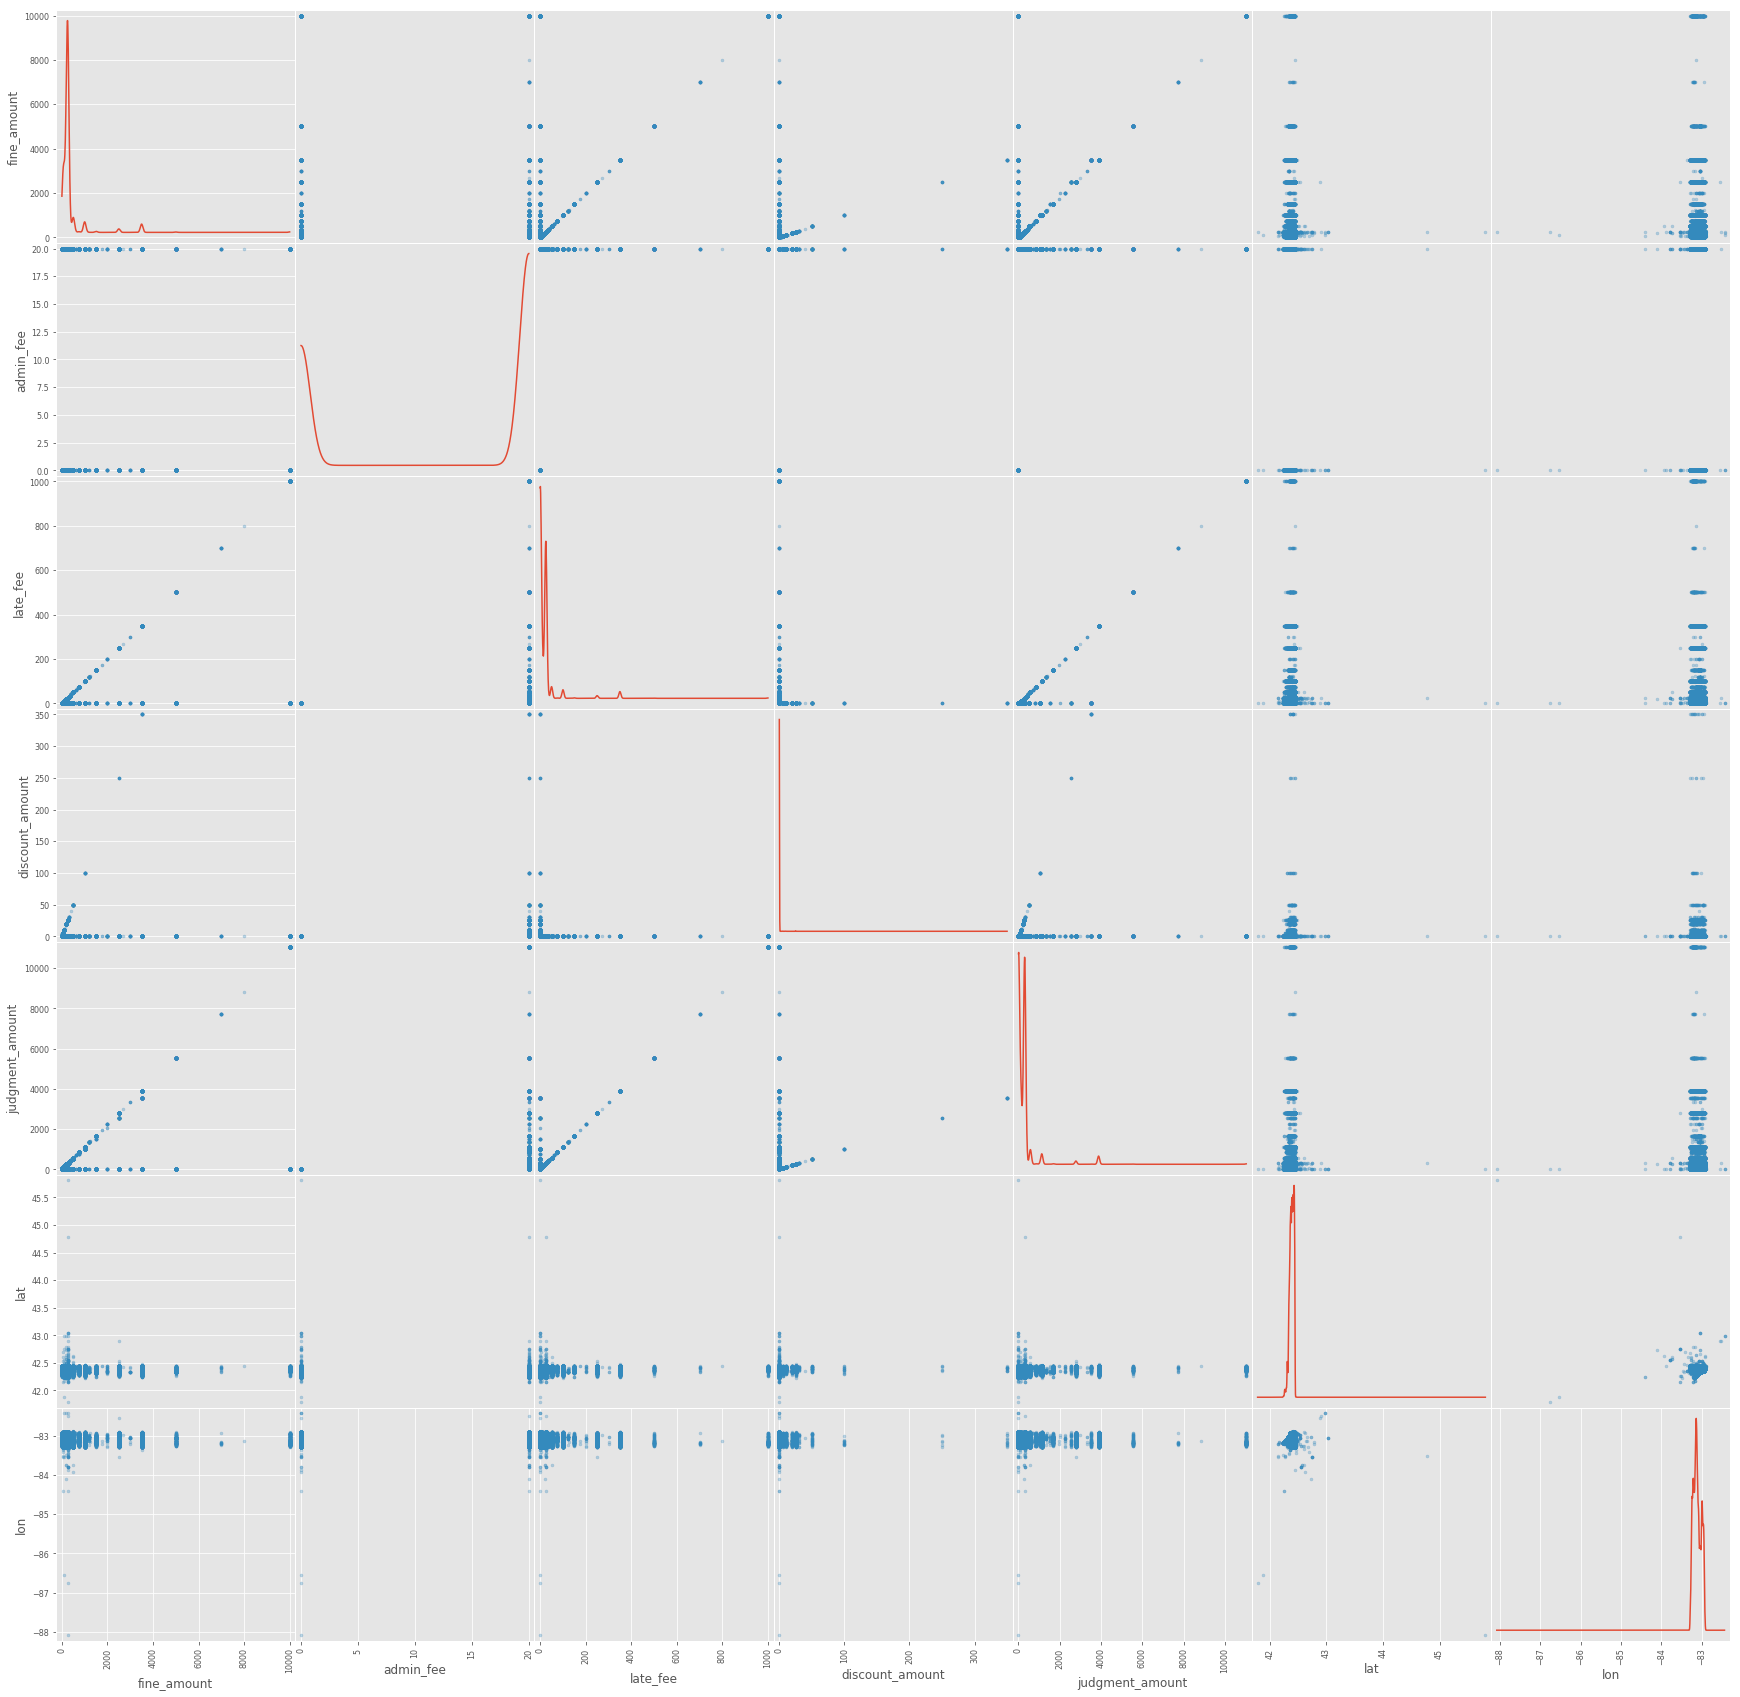

In [11]:
#from pandas import scatter_matrix
plt.style.use('ggplot')
plt.figure()

pd.scatter_matrix(train_data_merged[num_cols],
                  alpha=0.3,
                  figsize=(30, 30),
                  diagonal='kde');
                 #c=train_data_merged['compliance']                  
                  
plt.show()
#test_data_merged.describe()

In [7]:
train_data_merged[num_cols].corr()

,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,lat,lon
fine_amount,1.000000,-0.032694,-0.032694,0.712581,0.029248,NaN,0.712200,-0.006881,-0.014596
admin_fee,-0.032694,1.000000,1.000000,0.286289,0.027442,NaN,0.322319,0.021121,-0.001088
state_fee,-0.032694,1.000000,1.000000,0.286289,0.027442,NaN,0.322319,0.021121,-0.001088
late_fee,0.712581,0.286289,0.286289,1.000000,-0.013891,NaN,0.989371,0.006429,-0.017558
discount_amount,0.029248,0.027442,0.027442,-0.013891,1.000000,NaN,0.040895,0.000782,-0.005122
clean_up_cost,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
judgment_amount,0.712200,0.322319,0.322319,0.989371,0.040895,NaN,1.000000,0.004904,-0.018316
lat,-0.006881,0.021121,0.021121,0.006429,0.000782,NaN,0.004904,1.000000,0.146287
lon,-0.014596,-0.001088,-0.001088,-0.017558,-0.005122,NaN,-0.018316,0.146287,1.000000


In [9]:
train_data_merged['clean_up_cost'].value_counts()

0.0    250306
Name: clean_up_cost, dtype: int64

In [8]:
test_data_merged[num_cols].corr()

,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,lat,lon
fine_amount,1.000000,NaN,NaN,0.966931,0.034777,-0.019133,0.849734,-0.027252,0.006668
admin_fee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
state_fee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
late_fee,0.966931,NaN,NaN,1.000000,-0.051005,-0.016532,0.827941,-0.015192,0.005167
discount_amount,0.034777,NaN,NaN,-0.051005,1.000000,-0.002650,0.021893,-0.010391,0.001245
clean_up_cost,-0.019133,NaN,NaN,-0.016532,-0.002650,1.000000,0.509806,-0.026793,0.017874
judgment_amount,0.849734,NaN,NaN,0.827941,0.021893,0.509806,1.000000,-0.036734,0.015079
lat,-0.027252,NaN,NaN,-0.015192,-0.010391,-0.026793,-0.036734,1.000000,0.152644
lon,0.006668,NaN,NaN,0.005167,0.001245,0.017874,0.015079,0.152644,1.000000


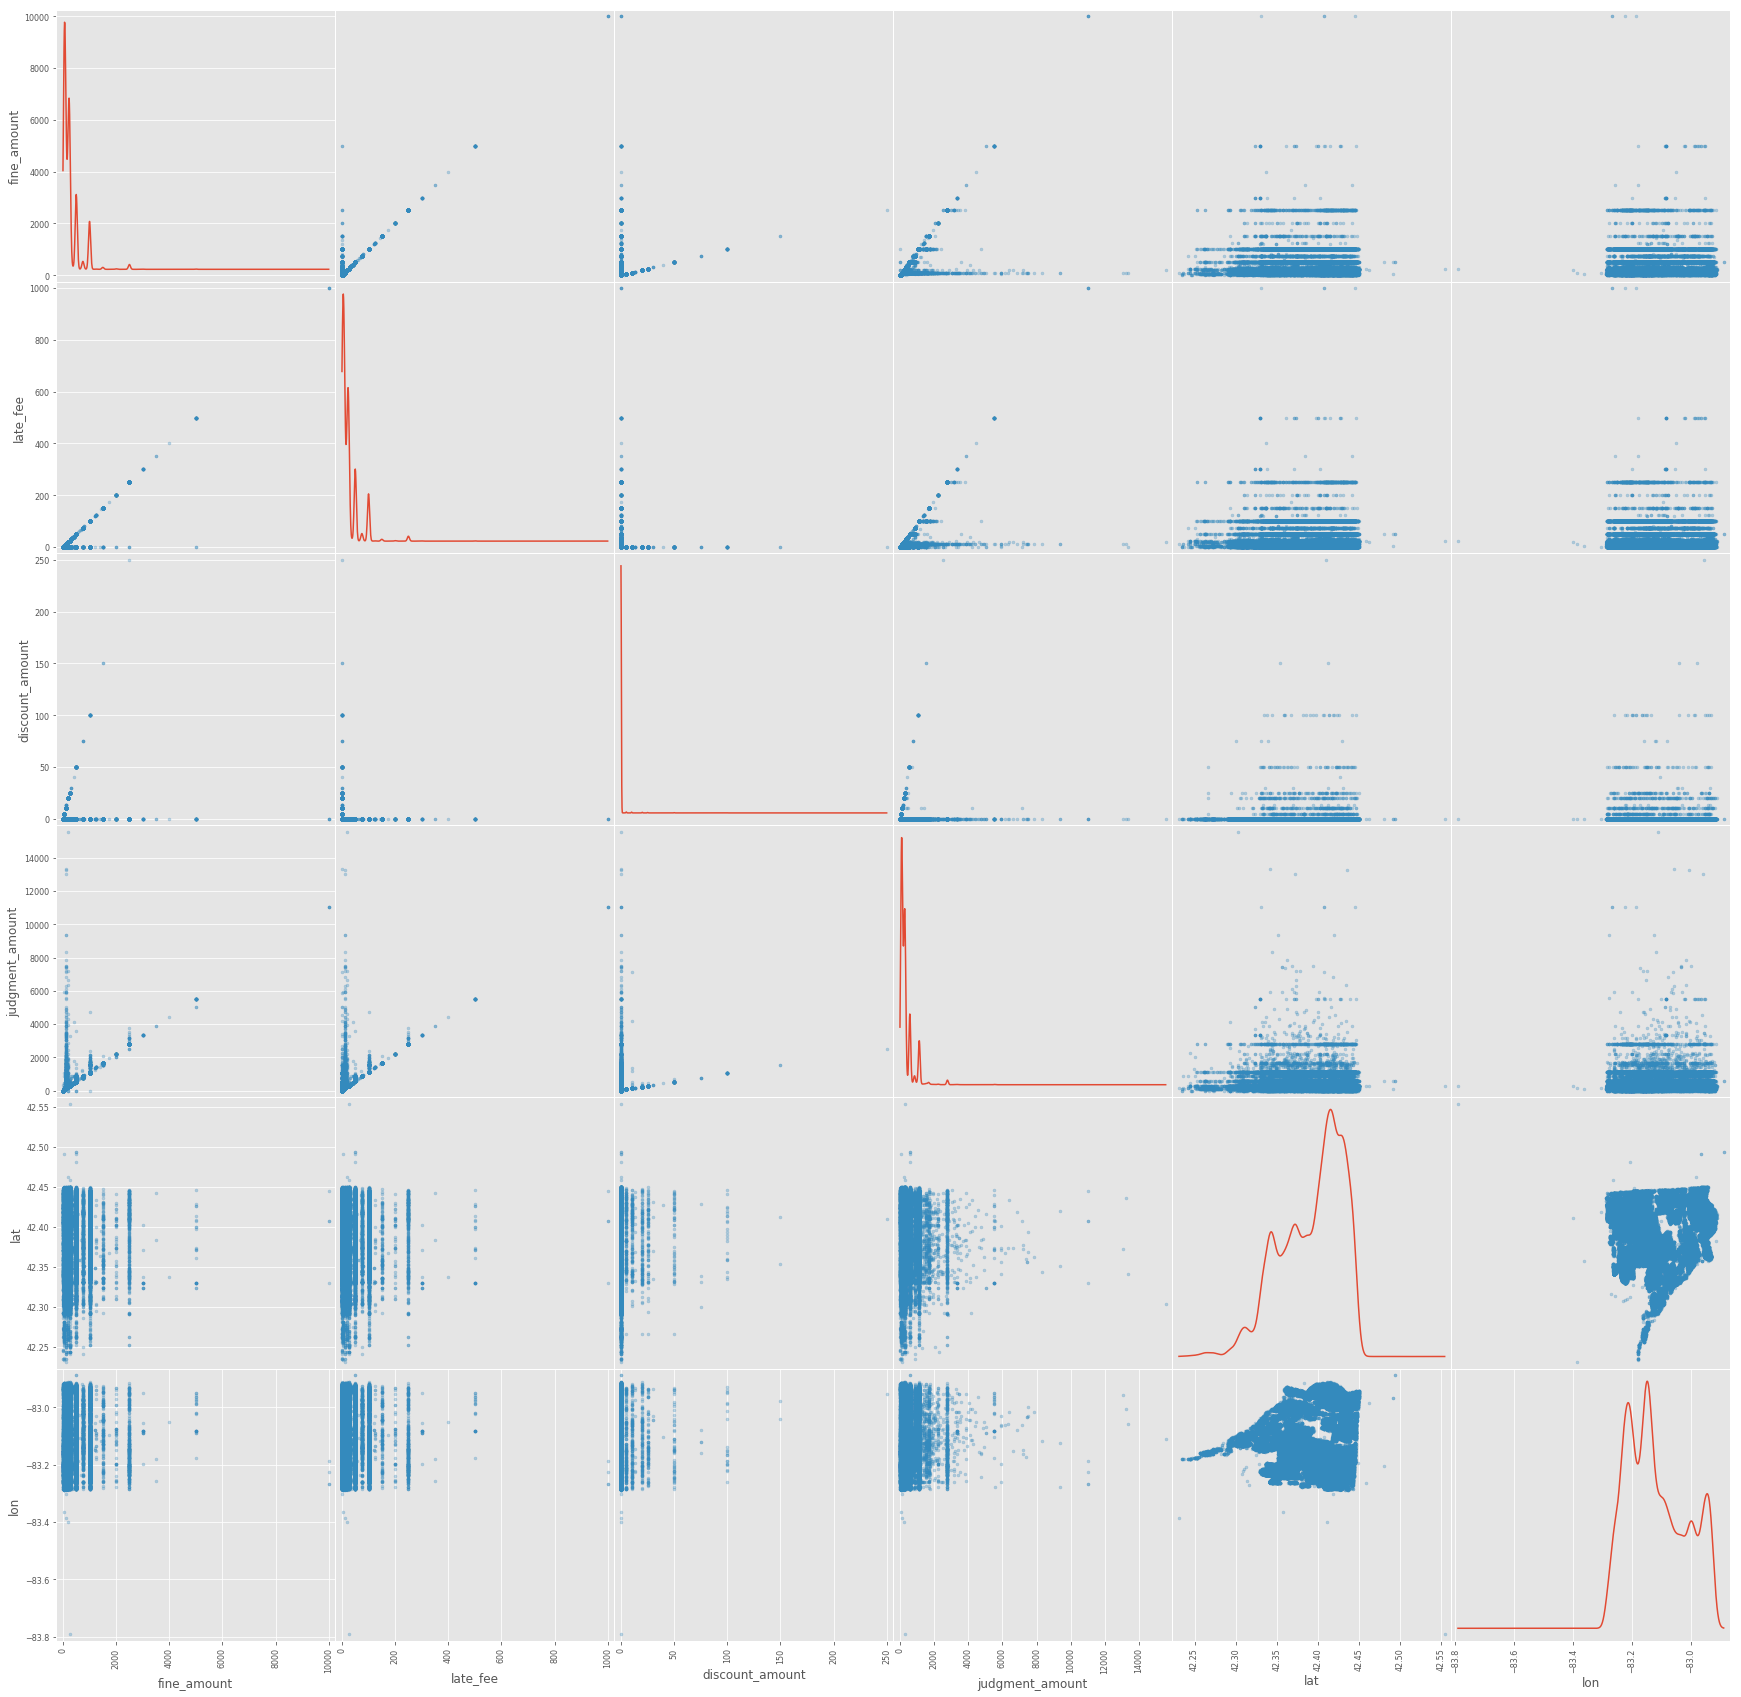

In [13]:
#from pandas import scatter_matrix
plt.style.use('ggplot')
plt.figure()

pd.scatter_matrix(test_data_merged[num_cols],
                  alpha=0.3,
                  figsize=(30, 30),
                  diagonal='kde');
                 #c=train_data_merged['compliance']                  
                  
plt.show()
#test_data_merged.describe()

In [14]:
train_data_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250306 entries, 0 to 250305
Data columns (total 37 columns):
ticket_id                     250306 non-null int64
agency_name                   250306 non-null object
inspector_name                250306 non-null object
violator_name                 250272 non-null object
violation_street_number       250306 non-null float64
violation_street_name         250306 non-null object
violation_zip_code            0 non-null float64
mailing_address_str_number    246704 non-null float64
mailing_address_str_name      250302 non-null object
city                          250306 non-null object
state                         250213 non-null object
zip_code                      250305 non-null object
non_us_str_code               3 non-null object
country                       250306 non-null object
ticket_issued_date            250306 non-null object
hearing_date                  237815 non-null object
violation_code                250306 non-null obj

In [15]:
test_data_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61001 entries, 0 to 61000
Data columns (total 30 columns):
ticket_id                     61001 non-null int64
agency_name                   61001 non-null object
inspector_name                61001 non-null object
violator_name                 60973 non-null object
violation_street_number       61001 non-null float64
violation_street_name         61001 non-null object
violation_zip_code            24024 non-null object
mailing_address_str_number    59987 non-null object
mailing_address_str_name      60998 non-null object
city                          61000 non-null object
state                         60670 non-null object
zip_code                      60998 non-null object
non_us_str_code               0 non-null float64
country                       61001 non-null object
ticket_issued_date            61001 non-null object
hearing_date                  58804 non-null object
violation_code                61001 non-null object
violation_

In [6]:
scaler = MinMaxScaler()
pd.DataFrame(scaler.fit_transform(train_data_merged[num_cols]),columns=num_cols).describe()


,fine_amount,late_fee,discount_amount,judgment_amount,lat,lon
count,159878.000000,159878.000000,159878.000000,159878.000000,159878.000000,159878.000000
mean,0.035704,0.033652,0.000560,0.038137,0.092605,0.683423
std,0.067566,0.067693,0.012258,0.067322,0.014060,0.049457
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.020000,0.010000,0.000000,0.022665,0.083056,0.644115
50%,0.025000,0.025000,0.000000,0.027652,0.093677,0.676552
75%,0.025000,0.025000,0.000000,0.027652,0.103746,0.724848
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
X = pd.DataFrame(scaler.fit_transform(train_data_merged[num_cols]),columns=num_cols)

In [8]:
X_cat = pd.get_dummies(train_data_merged[cat_cols]).reset_index().drop('index', axis=1)
#X_cat

In [9]:
X = pd.concat([X, 
               X_cat,
               train_data_merged['compliance'].reset_index().drop('index', axis=1)],
              axis=1)

In [10]:
split = StratifiedShuffleSplit(n_splits=1, test_size = 0.2, random_state = 42)
for train_index, val_index in split.split(X, X['compliance']):
    X_train = X.loc[train_index]
    X_val = X.loc[val_index]

In [11]:
y_train = X_train['compliance']
y_val = X_val['compliance']

In [12]:
X_train.drop('compliance', inplace=True, axis=1)
X_val.drop('compliance', inplace=True, axis=1)

In [13]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [14]:
y_pred = clf.predict_proba(X_val)

In [15]:
roc_auc_score(y_val, y_pred[:,0])

0.28330773739478732

In [11]:
for col in train_data.columns:
    print(col,": ", train_data[col].nunique())
    print(train_data[col].unique())

ticket_id :  250306
[ 22056  27586  22062 ..., 325562 325559 325561]
agency_name :  5
['Buildings, Safety Engineering & Env Department' 'Health Department'
 'Department of Public Works' 'Detroit Police Department'
 'Neighborhood City Halls']
inspector_name :  173
['Sims, Martinzie' 'Williams, Darrin' 'Jones, Leah' 'Zizi, Josue'
 'Gailes, Orbie J' 'Schuman, Randy' 'Rhodes, James' "O'Neal, Claude"
 'Matthews, Delos' 'Hayes, Billy J' 'Brinkley, Kevin' 'Funchess, Mitchell'
 'Brooks, Eric' 'Sharpe, Anthony' 'Smith, Louis' 'Snyder, Derrell'
 'Watson, Jerry' 'Houston, Doris' 'Sanders, Glen' 'Cato, Valesta'
 'Keys, Edna' 'Fountain, Michael' 'Devaney, John' 'Talbert, Reginald'
 'BENNETT, MARGARET' 'McCants, Angela' 'Stewart-Brown, Mamie'
 'Crawford, Kenneth' 'Thornton, Vaughn' 'Long, Phil' 'Stanford, Elton'
 'Langston, Yolanda' 'McCary, Peggy' 'Baker, Kenneth' 'Gardner, Arthur'
 "O'Neil, Vincent T" 'Steele, Jonathan' 'Purifoy, Lawrence'
 'Otis, Joseph D' 'Carver, Gharian' 'Johnson, Lois'
 'Mont

In [6]:
#train_data.columns
for column in train_data.columns:
    print()
    print(train_data[column].value_counts())

#print("Null count:",train_data.isnull().sum())


22517     1
31066     1
26968     1
53583     1
55630     1
49485     1
51532     1
61771     1
63818     1
59720     1
37191     1
39238     1
33093     1
35140     1
45379     1
47426     1
41281     1
43328     1
217407    1
219454    1
213309    1
215356    1
225595    1
227642    1
221497    1
223544    1
201015    1
203062    1
196917    1
24921     1
         ..
274223    1
87936     1
120720    1
112540    1
102299    1
100250    1
106393    1
104344    1
126871    1
124822    1
130965    1
128916    1
118675    1
116626    1
122769    1
77711     1
89985     1
75662     1
81805     1
79756     1
69515     1
67466     1
73609     1
71560     1
94087     1
92038     1
98181     1
96132     1
83842     1
20490     1
Name: ticket_id, dtype: int64

Buildings, Safety Engineering & Env Department    157784
Department of Public Works                         74717
Health Department                                   8903
Detroit Police Department                           8900
Neighbor

In [24]:
#addresses.join(latlons,on='address',how='inner')
train_data.drop['ticket_id', 'mailing_address_str_number','mailing_address_str_name','non_us_str_code','code','violation_description', inplace=True]
train_data['street']=train_data['violation_street_number','violation_street_name'].apply(x:str(x[0])+x[1])
train_data['zip_code'] =train_data['zip_code'].asdtype('str')

SyntaxError: invalid syntax (<ipython-input-24-cd4c1b32daa9>, line 2)

In [18]:
X_train = train_data[test_data.columns]
X_test = test_data
y_train = train_data['compliance']